    - In this project we have used the data for the complete month of August

In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
import seaborn as sns
from scipy.stats import spearmanr
import xgboost as xgb
from xgboost import XGBClassifier, to_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import glob

#### Data Wrangling

In [207]:
file_path = "./2025/AUG/GFDLCM_STOCK_01082025.csv"
def wrangle(file_path):
    df = pd.read_csv(file_path).set_index("Time")
    drop_columns = ["Ticker", "Date", "Volume", "Open Interest"]
    df = df.drop(columns=drop_columns)

    #Crate Features

    df["co"] = df["Close"] - df["Open"]
    df["ch"] = df["Close"] - df["High"]
    df["cl"] = df["Close"] - df["Low"]
    drop_columns = ["Open", "High", "Low"]
    df = df.drop(columns=drop_columns)

    #Create Target
    df["Return_15min"] = df["Close"].pct_change(periods=15) * 100
    df["Return_15min"] = df["Return_15min"].shift(-15)
    df = df.drop(columns=["Close"])
    df = df.dropna(how='any')
    df = df.copy()
    df.loc[:, "target"] = 0
    df.loc[df["Return_15min"] > 0.06, "target"] = 1
    df.loc[df["Return_15min"] < -0.05, "target"] = 2
    df = df.drop(columns=["Return_15min"])
    # print(df["target"].value_counts())
    
    return df

In [208]:
files = sorted(glob.glob("./2025/AUG/GFDLCM_STOCK_*.csv"))

all_dfs = []

for f in files:
    processed_df = wrangle(f)
    all_dfs.append(processed_df)

# Concatenate into one big dataframe
final_df = pd.concat(all_dfs, ignore_index=True)


print("\nFinal combined shape:", final_df.shape)
print(final_df["target"].value_counts())



Final combined shape: (6382, 4)
target
2    2374
0    2077
1    1931
Name: count, dtype: int64


In [209]:
print(final_df.shape)
final_df.head()

(6382, 4)


,co,ch,cl,target
0,1.0,-2.3,3.6,1
1,1.0,-1.7,1.0,1
2,0.6,-1.2,2.4,1
3,0.2,-1.1,1.6,1
4,1.4,-1.2,1.6,1


In [210]:
df = final_df.copy()

In [211]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [212]:
print(X.head())

    co   ch   cl
0  1.0 -2.3  3.6
1  1.0 -1.7  1.0
2  0.6 -1.2  2.4
3  0.2 -1.1  1.6
4  1.4 -1.2  1.6


In [213]:
print(X.shape)

(6382, 3)


In [214]:
print(y.head())

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64


In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [216]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2, shuffle=True, random_state=42)

#### Decision Tree Classifier

In [217]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

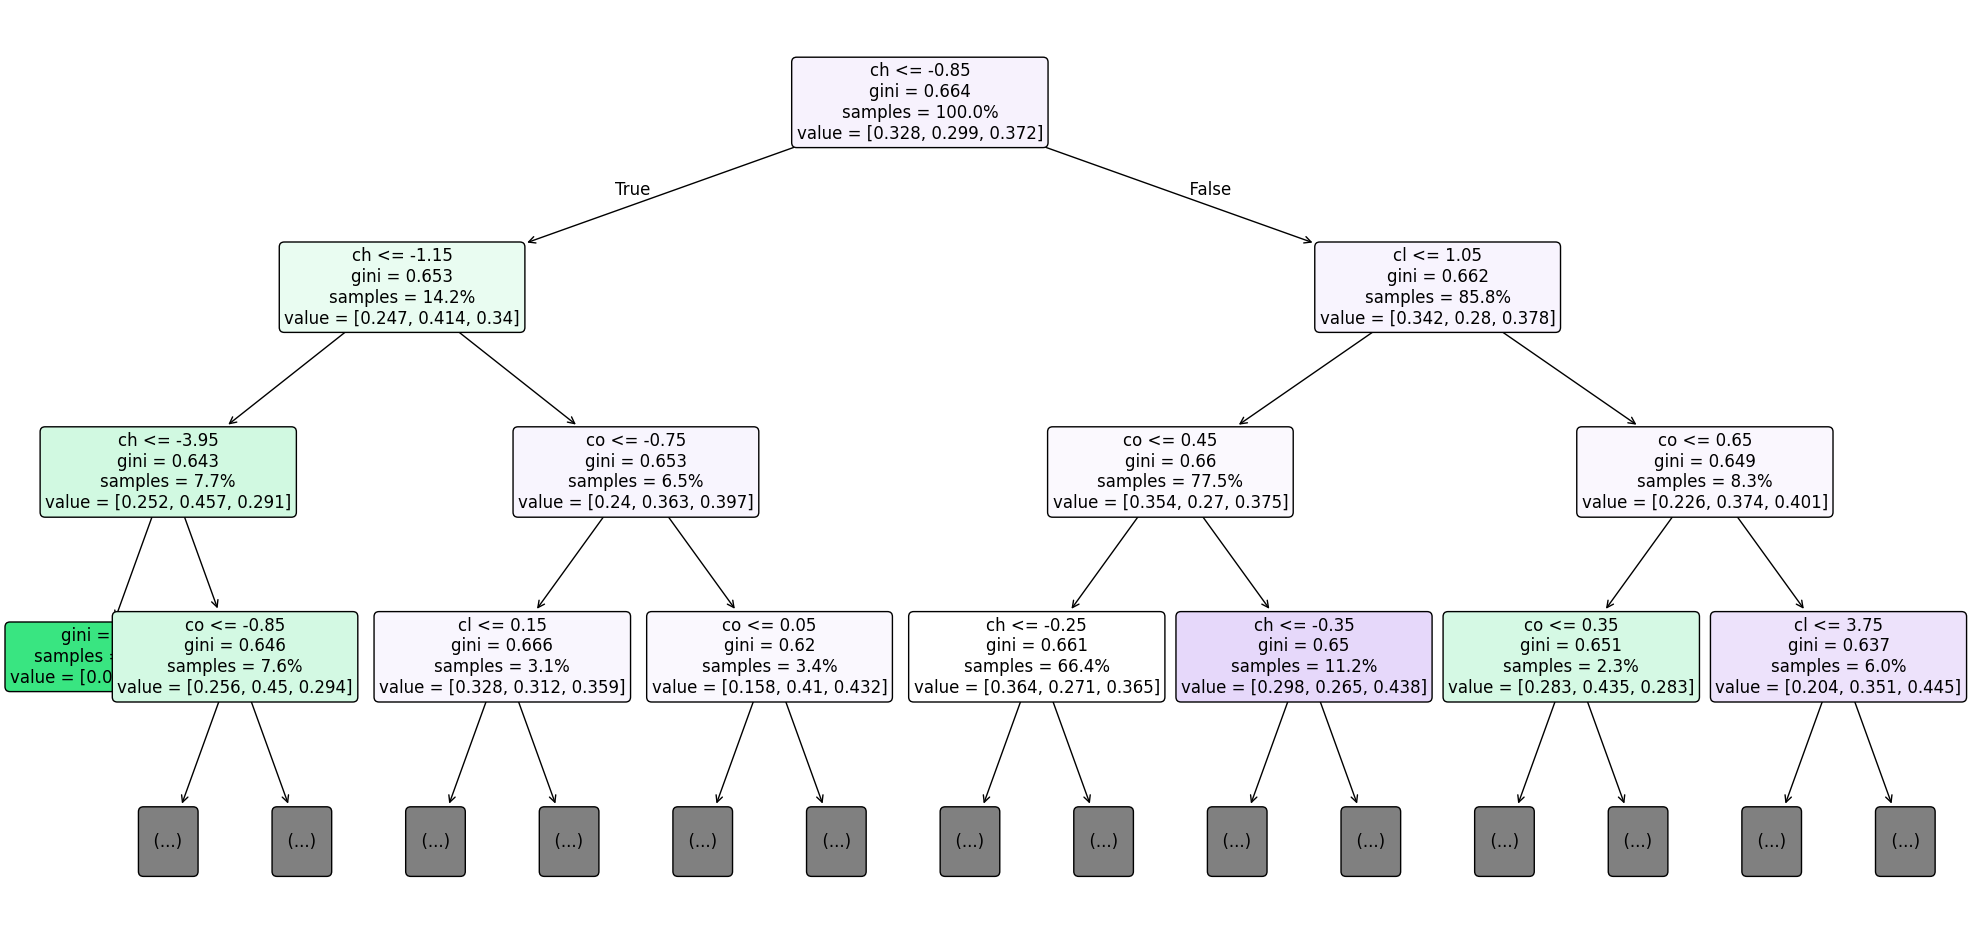

In [218]:
fig, ax = plt.subplots(figsize=(25,12))
#Plot tree
plot_tree(
    dt,
    feature_names= X_train.columns,
    filled=True, #Color leaf with classes
    rounded=True, #Round leaf edges
    proportion=True, #Display proportion of classes in leaf
    max_depth=3, #Only display first three levels
    fontsize=12, #Enlarge Font
    ax=ax #Place in figure axis
);

In [219]:
acc_train = accuracy_score(y_train, dt.predict(X_train))
acc_val = accuracy_score(y_val, dt.predict(X_val))

print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_val, 2))

Training Accuracy: 0.62
Validation Accuracy: 0.36


In [220]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[175 106 135]
 [158  91 148]
 [210 103 151]]


In [221]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.32      0.42      0.36       416
           1       0.30      0.23      0.26       397
           2       0.35      0.33      0.34       464

    accuracy                           0.33      1277
   macro avg       0.32      0.33      0.32      1277
weighted avg       0.33      0.33      0.32      1277



In [222]:
depth_hyperparams = range(1,50,2)

In [223]:
training_acc =  []
validation_acc = []
for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = DecisionTreeClassifier(random_state=42, max_depth=d)
        
    #Fit model to the training data
    test_model.fit(X_train, y_train)
    #Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train,y_train))
    #Calculate validation accuracy score and append to `validation_acc`
    validation_acc.append(test_model.score(X_val,y_val))

print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])


Training Accuracy Scores: [0.3829578844270323, 0.3885896180215475, 0.41234084231145934]
Validation Accuracy Scores: [0.3682664054848188, 0.376101860920666, 0.3692458374142997]


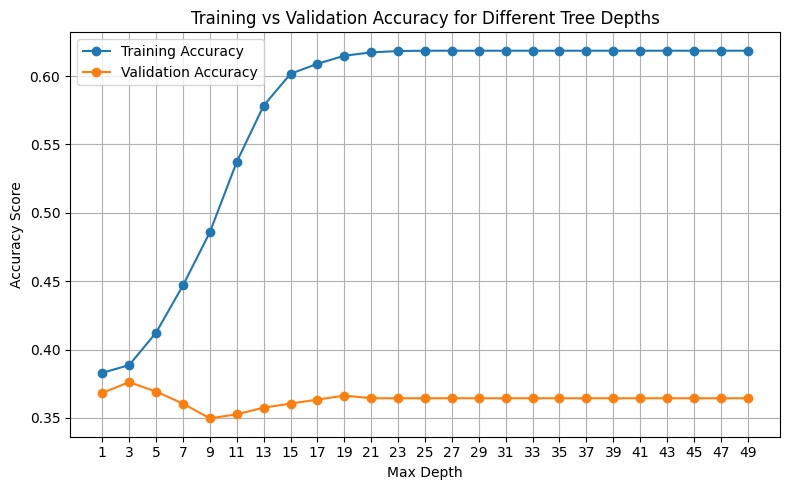

In [224]:
plt.figure(figsize=(8,5))

plt.plot(depth_hyperparams, training_acc, marker='o', label="Training Accuracy")
plt.plot(depth_hyperparams, validation_acc, marker='o', label="Validation Accuracy")


plt.xticks(depth_hyperparams)

plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title("Training vs Validation Accuracy for Different Tree Depths")

plt.grid(True)  # Add grid
plt.legend()
plt.tight_layout()
plt.show()


In [225]:
best_dt = DecisionTreeClassifier(
   max_depth=3
)

In [226]:
best_dt.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [227]:
y_pred = best_dt.predict(X_test)

In [228]:
acc_train = accuracy_score(y_train, dt.predict(X_train))
acc_val = accuracy_score(y_val, dt.predict(X_val))

In [229]:
print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_val, 2))

Training Accuracy: 0.62
Validation Accuracy: 0.36


In [230]:
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[  0  41 375]
 [  0  52 345]
 [  0  39 425]]


In [231]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       416
           1       0.39      0.13      0.20       397
           2       0.37      0.92      0.53       464

    accuracy                           0.37      1277
   macro avg       0.26      0.35      0.24      1277
weighted avg       0.26      0.37      0.25      1277



d:\Day 1 to 15\machine_learning_training\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Day 1 to 15\machine_learning_training\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Day 1 to 15\machine_learning_training\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is